# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

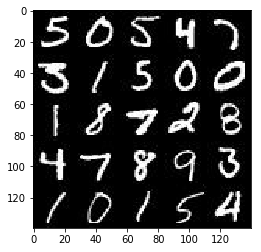

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

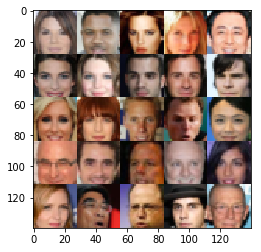

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learn_rate = tf.placeholder(tf.float32, (), name="learn_rate")

    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28x3
        
        x1 = tf.layers.conv2d(images, 32, 4, strides=1, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        # 28x28x32
        
        x12 = tf.layers.conv2d(relu1, 64, 4, strides=2, padding='same')
        bn12 = tf.layers.batch_normalization(x12, training=True)
        relu12 = tf.maximum(alpha * bn12, bn12)
        
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu12, 128, 4, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # 14x14x128
        
        x3 = tf.layers.conv2d(relu2, 256, 4, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # 7x7x256
        
        x4 = tf.layers.conv2d(relu3, 512, 4, strides=1, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        
        # 7x7x512
        
        flat = tf.reshape(relu4, (-1, 7*7*512)) 
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:

def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # fully connected
        x1 = tf.layers.dense(z, (7*7*512))
        x1 = tf.reshape(x1, (-1, 7, 7, 512)) # reshape to start the conv
        # bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * x1, x1) #leaky relu

        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 4, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2) #leaky relu
        
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 4, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3) #leaky relu
        
        # 14x14x128
        
        x4 = tf.layers.conv2d_transpose(relu3, 64, 4, strides=1, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        relu4 = tf.maximum(alpha * bn4, bn4) #leaky relu

        # 14x14x64
        
        x5 = tf.layers.conv2d_transpose(relu4, 32, 4, strides=2, padding='same')
        bn5 = tf.layers.batch_normalization(x5, training=is_train)
        relu5 = tf.maximum(alpha * bn5, bn5) #leaky relu
        
        # 28x28x32
        
        logits = tf.layers.conv2d_transpose(relu5, out_channel_dim, 4, strides=1, padding='same')
        
        # 28x28x3

        out = tf.tanh(logits)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.85))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [v for v in t_vars if v.name.startswith('discriminator')]
    g_vars = [v for v in t_vars if v.name.startswith('generator')]

    # optimization
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    img_channels = 1 if data_image_mode == "L" else 3
    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[1], img_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images*2
                # random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % 5 == 0:
                    # get train losses and print
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # save losses to view after training
                    # losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, img_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7965... Generator Loss: 3.1254
Epoch 1/2... Discriminator Loss: 1.8416... Generator Loss: 0.5400
Epoch 1/2... Discriminator Loss: 1.9964... Generator Loss: 0.5887
Epoch 1/2... Discriminator Loss: 1.0325... Generator Loss: 2.0237
Epoch 1/2... Discriminator Loss: 3.3079... Generator Loss: 10.5978
Epoch 1/2... Discriminator Loss: 4.8396... Generator Loss: 0.0289
Epoch 1/2... Discriminator Loss: 2.0340... Generator Loss: 0.5474
Epoch 1/2... Discriminator Loss: 2.6737... Generator Loss: 5.2803
Epoch 1/2... Discriminator Loss: 1.5593... Generator Loss: 0.6898
Epoch 1/2... Discriminator Loss: 1.4261... Generator Loss: 1.6054
Epoch 1/2... Discriminator Loss: 0.9168... Generator Loss: 1.5786
Epoch 1/2... Discriminator Loss: 2.4283... Generator Loss: 4.8879
Epoch 1/2... Discriminator Loss: 0.8034... Generator Loss: 2.4118
Epoch 1/2... Discriminator Loss: 0.8608... Generator Loss: 1.5757
Epoch 1/2... Discriminator Loss: 2.3648... Generator Loss: 0.2454
Epoch 1/2

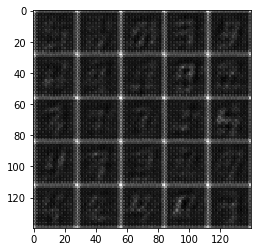

Epoch 1/2... Discriminator Loss: 1.0218... Generator Loss: 1.1754
Epoch 1/2... Discriminator Loss: 1.7788... Generator Loss: 4.2945
Epoch 1/2... Discriminator Loss: 1.0335... Generator Loss: 2.3136
Epoch 1/2... Discriminator Loss: 0.8213... Generator Loss: 1.8259
Epoch 1/2... Discriminator Loss: 1.2851... Generator Loss: 0.7540
Epoch 1/2... Discriminator Loss: 0.9235... Generator Loss: 1.3324
Epoch 1/2... Discriminator Loss: 1.3973... Generator Loss: 3.5854
Epoch 1/2... Discriminator Loss: 1.0904... Generator Loss: 0.9993
Epoch 1/2... Discriminator Loss: 0.9029... Generator Loss: 1.7255
Epoch 1/2... Discriminator Loss: 2.0441... Generator Loss: 4.8743
Epoch 1/2... Discriminator Loss: 0.8393... Generator Loss: 1.6276
Epoch 1/2... Discriminator Loss: 1.7303... Generator Loss: 0.4902
Epoch 1/2... Discriminator Loss: 1.1679... Generator Loss: 0.9309
Epoch 1/2... Discriminator Loss: 0.8818... Generator Loss: 2.6738
Epoch 1/2... Discriminator Loss: 1.1450... Generator Loss: 1.0102
Epoch 1/2.

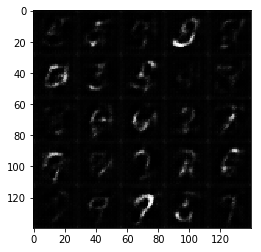

Epoch 1/2... Discriminator Loss: 1.0212... Generator Loss: 1.0379
Epoch 1/2... Discriminator Loss: 0.9469... Generator Loss: 2.2925
Epoch 1/2... Discriminator Loss: 1.5658... Generator Loss: 3.6252
Epoch 1/2... Discriminator Loss: 0.8928... Generator Loss: 1.2709
Epoch 1/2... Discriminator Loss: 1.3089... Generator Loss: 3.4746
Epoch 1/2... Discriminator Loss: 0.9084... Generator Loss: 2.2085
Epoch 1/2... Discriminator Loss: 1.1354... Generator Loss: 0.9318
Epoch 1/2... Discriminator Loss: 0.9311... Generator Loss: 1.7616
Epoch 1/2... Discriminator Loss: 0.9771... Generator Loss: 1.1458
Epoch 1/2... Discriminator Loss: 1.8993... Generator Loss: 4.1334
Epoch 1/2... Discriminator Loss: 0.8712... Generator Loss: 1.8906
Epoch 1/2... Discriminator Loss: 1.2046... Generator Loss: 0.9350
Epoch 1/2... Discriminator Loss: 1.1252... Generator Loss: 0.9601
Epoch 1/2... Discriminator Loss: 1.1070... Generator Loss: 2.4232
Epoch 1/2... Discriminator Loss: 0.9347... Generator Loss: 1.2455
Epoch 1/2.

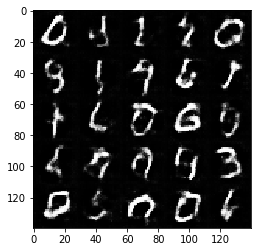

Epoch 1/2... Discriminator Loss: 0.8394... Generator Loss: 2.0228
Epoch 1/2... Discriminator Loss: 0.8562... Generator Loss: 1.3908
Epoch 1/2... Discriminator Loss: 0.8212... Generator Loss: 1.6532
Epoch 1/2... Discriminator Loss: 0.9184... Generator Loss: 1.1764
Epoch 1/2... Discriminator Loss: 1.6309... Generator Loss: 0.5653
Epoch 1/2... Discriminator Loss: 6.4077... Generator Loss: 8.7545
Epoch 1/2... Discriminator Loss: 2.1524... Generator Loss: 0.3513
Epoch 1/2... Discriminator Loss: 1.2220... Generator Loss: 1.0081
Epoch 1/2... Discriminator Loss: 0.9711... Generator Loss: 1.3802
Epoch 1/2... Discriminator Loss: 1.0516... Generator Loss: 1.0466
Epoch 1/2... Discriminator Loss: 1.3978... Generator Loss: 0.7289
Epoch 1/2... Discriminator Loss: 0.9945... Generator Loss: 1.1084
Epoch 1/2... Discriminator Loss: 0.8078... Generator Loss: 1.9319
Epoch 1/2... Discriminator Loss: 0.9420... Generator Loss: 1.3458
Epoch 1/2... Discriminator Loss: 1.2715... Generator Loss: 0.7683
Epoch 1/2.

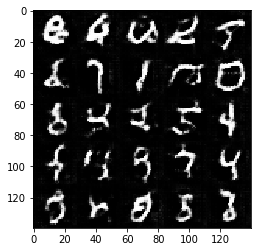

Epoch 1/2... Discriminator Loss: 0.8783... Generator Loss: 1.6316
Epoch 1/2... Discriminator Loss: 1.1454... Generator Loss: 0.8680
Epoch 1/2... Discriminator Loss: 0.9603... Generator Loss: 1.2339
Epoch 1/2... Discriminator Loss: 1.2114... Generator Loss: 0.7659
Epoch 1/2... Discriminator Loss: 0.8766... Generator Loss: 1.6782
Epoch 1/2... Discriminator Loss: 1.2454... Generator Loss: 2.2762
Epoch 1/2... Discriminator Loss: 2.5633... Generator Loss: 2.4806
Epoch 1/2... Discriminator Loss: 1.6588... Generator Loss: 3.0366
Epoch 1/2... Discriminator Loss: 1.3488... Generator Loss: 0.7524
Epoch 1/2... Discriminator Loss: 1.0222... Generator Loss: 1.5530
Epoch 1/2... Discriminator Loss: 0.9851... Generator Loss: 1.4284
Epoch 1/2... Discriminator Loss: 1.0034... Generator Loss: 1.5571
Epoch 1/2... Discriminator Loss: 1.0410... Generator Loss: 1.0734
Epoch 2/2... Discriminator Loss: 0.9871... Generator Loss: 1.6463
Epoch 2/2... Discriminator Loss: 1.1290... Generator Loss: 0.8768
Epoch 2/2.

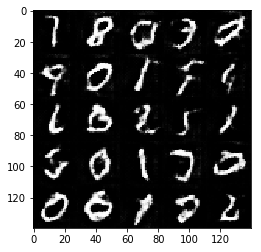

Epoch 2/2... Discriminator Loss: 0.8849... Generator Loss: 1.5480
Epoch 2/2... Discriminator Loss: 1.5147... Generator Loss: 0.6037
Epoch 2/2... Discriminator Loss: 1.2933... Generator Loss: 2.5421
Epoch 2/2... Discriminator Loss: 1.1087... Generator Loss: 1.1322
Epoch 2/2... Discriminator Loss: 1.1674... Generator Loss: 0.8907
Epoch 2/2... Discriminator Loss: 0.9311... Generator Loss: 1.2350
Epoch 2/2... Discriminator Loss: 0.9232... Generator Loss: 1.8222
Epoch 2/2... Discriminator Loss: 0.9317... Generator Loss: 1.3415
Epoch 2/2... Discriminator Loss: 0.9122... Generator Loss: 1.7683
Epoch 2/2... Discriminator Loss: 1.2244... Generator Loss: 0.8549
Epoch 2/2... Discriminator Loss: 1.5920... Generator Loss: 2.9447
Epoch 2/2... Discriminator Loss: 1.0570... Generator Loss: 1.0596
Epoch 2/2... Discriminator Loss: 1.1015... Generator Loss: 0.9204
Epoch 2/2... Discriminator Loss: 0.9435... Generator Loss: 1.2325
Epoch 2/2... Discriminator Loss: 0.9625... Generator Loss: 1.3836
Epoch 2/2.

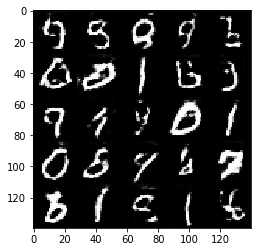

Epoch 2/2... Discriminator Loss: 0.8228... Generator Loss: 1.5592
Epoch 2/2... Discriminator Loss: 1.4991... Generator Loss: 0.5425
Epoch 2/2... Discriminator Loss: 1.4766... Generator Loss: 0.5975
Epoch 2/2... Discriminator Loss: 0.9959... Generator Loss: 2.0704
Epoch 2/2... Discriminator Loss: 0.9590... Generator Loss: 1.2940
Epoch 2/2... Discriminator Loss: 1.0980... Generator Loss: 0.9200
Epoch 2/2... Discriminator Loss: 0.9719... Generator Loss: 1.1166
Epoch 2/2... Discriminator Loss: 1.2218... Generator Loss: 0.7719
Epoch 2/2... Discriminator Loss: 1.0884... Generator Loss: 0.9401
Epoch 2/2... Discriminator Loss: 0.9081... Generator Loss: 1.3130
Epoch 2/2... Discriminator Loss: 0.9206... Generator Loss: 1.3596
Epoch 2/2... Discriminator Loss: 0.9432... Generator Loss: 1.5125
Epoch 2/2... Discriminator Loss: 1.5233... Generator Loss: 0.5848
Epoch 2/2... Discriminator Loss: 1.3579... Generator Loss: 2.4422
Epoch 2/2... Discriminator Loss: 1.3775... Generator Loss: 0.6674
Epoch 2/2.

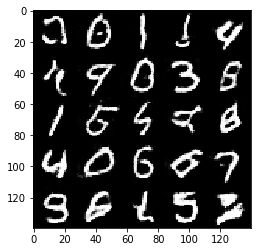

Epoch 2/2... Discriminator Loss: 1.3696... Generator Loss: 0.6834
Epoch 2/2... Discriminator Loss: 1.3392... Generator Loss: 0.6628
Epoch 2/2... Discriminator Loss: 0.9890... Generator Loss: 1.1092
Epoch 2/2... Discriminator Loss: 1.3123... Generator Loss: 0.6711
Epoch 2/2... Discriminator Loss: 1.0206... Generator Loss: 1.3163
Epoch 2/2... Discriminator Loss: 0.9999... Generator Loss: 1.0809
Epoch 2/2... Discriminator Loss: 1.4503... Generator Loss: 0.5811
Epoch 2/2... Discriminator Loss: 1.1388... Generator Loss: 0.8868
Epoch 2/2... Discriminator Loss: 0.9951... Generator Loss: 1.8771
Epoch 2/2... Discriminator Loss: 1.1133... Generator Loss: 0.9230
Epoch 2/2... Discriminator Loss: 1.0081... Generator Loss: 2.0001
Epoch 2/2... Discriminator Loss: 2.1400... Generator Loss: 0.2865
Epoch 2/2... Discriminator Loss: 1.0515... Generator Loss: 1.2414
Epoch 2/2... Discriminator Loss: 1.2938... Generator Loss: 0.7639
Epoch 2/2... Discriminator Loss: 0.9901... Generator Loss: 1.3097
Epoch 2/2.

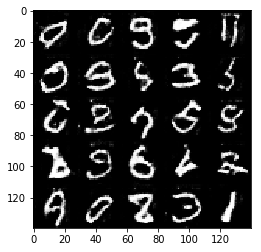

Epoch 2/2... Discriminator Loss: 1.0763... Generator Loss: 1.0569
Epoch 2/2... Discriminator Loss: 1.4412... Generator Loss: 0.6977
Epoch 2/2... Discriminator Loss: 1.1544... Generator Loss: 0.8968
Epoch 2/2... Discriminator Loss: 1.0645... Generator Loss: 0.9667
Epoch 2/2... Discriminator Loss: 0.8517... Generator Loss: 2.1955
Epoch 2/2... Discriminator Loss: 1.3786... Generator Loss: 0.6526
Epoch 2/2... Discriminator Loss: 2.1745... Generator Loss: 2.9357
Epoch 2/2... Discriminator Loss: 1.1414... Generator Loss: 1.8147
Epoch 2/2... Discriminator Loss: 1.0178... Generator Loss: 1.6166
Epoch 2/2... Discriminator Loss: 0.9365... Generator Loss: 1.3646
Epoch 2/2... Discriminator Loss: 1.2456... Generator Loss: 0.8031
Epoch 2/2... Discriminator Loss: 1.2025... Generator Loss: 0.8298
Epoch 2/2... Discriminator Loss: 0.9651... Generator Loss: 2.1947
Epoch 2/2... Discriminator Loss: 1.0201... Generator Loss: 1.1382
Epoch 2/2... Discriminator Loss: 0.8578... Generator Loss: 2.2409
Epoch 2/2.

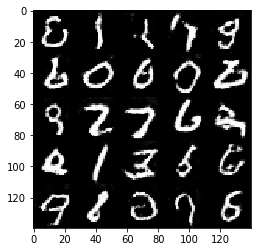

Epoch 2/2... Discriminator Loss: 2.1319... Generator Loss: 0.3287
Epoch 2/2... Discriminator Loss: 1.0701... Generator Loss: 1.2326
Epoch 2/2... Discriminator Loss: 0.9969... Generator Loss: 2.1966
Epoch 2/2... Discriminator Loss: 1.1511... Generator Loss: 0.9231
Epoch 2/2... Discriminator Loss: 1.5372... Generator Loss: 0.5941
Epoch 2/2... Discriminator Loss: 1.0700... Generator Loss: 2.8874
Epoch 2/2... Discriminator Loss: 1.0119... Generator Loss: 1.1735


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0156... Generator Loss: 1.6027
Epoch 1/1... Discriminator Loss: 1.0806... Generator Loss: 4.4789
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 8.6601
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 1.2381
Epoch 1/1... Discriminator Loss: 0.7952... Generator Loss: 2.5304
Epoch 1/1... Discriminator Loss: 1.7886... Generator Loss: 0.5988
Epoch 1/1... Discriminator Loss: 0.5667... Generator Loss: 4.0839
Epoch 1/1... Discriminator Loss: 0.8695... Generator Loss: 10.3027
Epoch 1/1... Discriminator Loss: 2.0218... Generator Loss: 24.1194
Epoch 1/1... Discriminator Loss: 0.7713... Generator Loss: 5.9948
Epoch 1/1... Discriminator Loss: 2.4759... Generator Loss: 0.4017
Epoch 1/1... Discriminator Loss: 0.8357... Generator Loss: 3.2436
Epoch 1/1... Discriminator Loss: 1.5103... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 0.7276... Generator Loss: 3.4327
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 1.2312
Epoch 1/

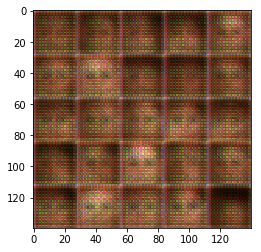

Epoch 1/1... Discriminator Loss: 0.8145... Generator Loss: 2.9013
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 1.1889
Epoch 1/1... Discriminator Loss: 0.8262... Generator Loss: 3.5200
Epoch 1/1... Discriminator Loss: 0.5785... Generator Loss: 3.2920
Epoch 1/1... Discriminator Loss: 0.8983... Generator Loss: 1.3332
Epoch 1/1... Discriminator Loss: 0.8497... Generator Loss: 4.5068
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 6.2651
Epoch 1/1... Discriminator Loss: 0.7764... Generator Loss: 1.8499
Epoch 1/1... Discriminator Loss: 0.7180... Generator Loss: 3.1339
Epoch 1/1... Discriminator Loss: 0.7021... Generator Loss: 3.6674
Epoch 1/1... Discriminator Loss: 0.8395... Generator Loss: 4.8399
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 6.5325
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 1.1328
Epoch 1/1... Discriminator Loss: 0.7240... Generator Loss: 2.2220
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 5.6353
Epoch 1/1.

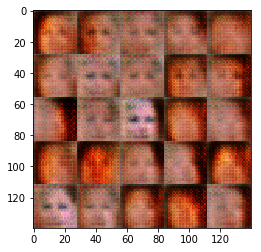

Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 1.2438
Epoch 1/1... Discriminator Loss: 0.7297... Generator Loss: 2.1186
Epoch 1/1... Discriminator Loss: 0.7009... Generator Loss: 2.1682
Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 1.4129
Epoch 1/1... Discriminator Loss: 0.7894... Generator Loss: 2.3150
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 0.6439... Generator Loss: 2.4969
Epoch 1/1... Discriminator Loss: 0.7043... Generator Loss: 2.4064
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 0.7882... Generator Loss: 1.7399
Epoch 1/1... Discriminator Loss: 2.0764... Generator Loss: 5.9707
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 4.1224
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 1.0385
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 1.3225
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 1.8065
Epoch 1/1.

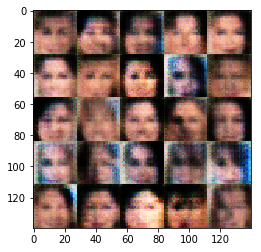

Epoch 1/1... Discriminator Loss: 0.6657... Generator Loss: 2.6164
Epoch 1/1... Discriminator Loss: 0.9051... Generator Loss: 1.3850
Epoch 1/1... Discriminator Loss: 0.7534... Generator Loss: 2.2172
Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 1.1440
Epoch 1/1... Discriminator Loss: 0.7473... Generator Loss: 2.2224
Epoch 1/1... Discriminator Loss: 0.8501... Generator Loss: 1.5235
Epoch 1/1... Discriminator Loss: 0.9410... Generator Loss: 2.9575
Epoch 1/1... Discriminator Loss: 0.8250... Generator Loss: 2.6317
Epoch 1/1... Discriminator Loss: 0.7511... Generator Loss: 2.2021
Epoch 1/1... Discriminator Loss: 0.8000... Generator Loss: 3.0634
Epoch 1/1... Discriminator Loss: 0.7565... Generator Loss: 2.7655
Epoch 1/1... Discriminator Loss: 1.0123... Generator Loss: 1.2362
Epoch 1/1... Discriminator Loss: 0.8112... Generator Loss: 1.5250
Epoch 1/1... Discriminator Loss: 1.9740... Generator Loss: 0.5110
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 1.0615
Epoch 1/1.

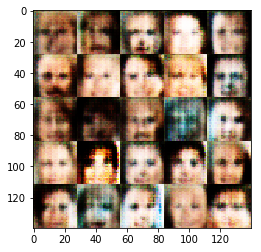

Epoch 1/1... Discriminator Loss: 0.6880... Generator Loss: 2.9153
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 5.0971
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 0.7224... Generator Loss: 2.1264
Epoch 1/1... Discriminator Loss: 0.7940... Generator Loss: 1.9854
Epoch 1/1... Discriminator Loss: 0.8010... Generator Loss: 2.9094
Epoch 1/1... Discriminator Loss: 0.6040... Generator Loss: 2.8083
Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 3.4276
Epoch 1/1... Discriminator Loss: 0.8346... Generator Loss: 1.4991
Epoch 1/1... Discriminator Loss: 1.9598... Generator Loss: 0.3807
Epoch 1/1... Discriminator Loss: 0.7445... Generator Loss: 2.3709
Epoch 1/1... Discriminator Loss: 0.8697... Generator Loss: 1.5275
Epoch 1/1... Discriminator Loss: 1.7511... Generator Loss: 0.4747
Epoch 1/1... Discriminator Loss: 0.6356... Generator Loss: 2.7960
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.6404
Epoch 1/1.

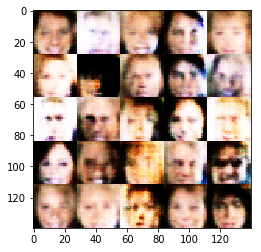

Epoch 1/1... Discriminator Loss: 0.6333... Generator Loss: 2.3045
Epoch 1/1... Discriminator Loss: 0.6533... Generator Loss: 2.1496
Epoch 1/1... Discriminator Loss: 0.9156... Generator Loss: 1.5801
Epoch 1/1... Discriminator Loss: 0.8263... Generator Loss: 1.6822
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 1.0203
Epoch 1/1... Discriminator Loss: 0.8664... Generator Loss: 1.3742
Epoch 1/1... Discriminator Loss: 0.9650... Generator Loss: 1.1314
Epoch 1/1... Discriminator Loss: 1.7328... Generator Loss: 5.9854
Epoch 1/1... Discriminator Loss: 1.5407... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 0.6652... Generator Loss: 2.4942
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 4.0194
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 1.3623
Epoch 1/1... Discriminator Loss: 0.5866... Generator Loss: 4.3487
Epoch 1/1... Discriminator Loss: 0.7695... Generator Loss: 2.1420
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 3.5441
Epoch 1/1.

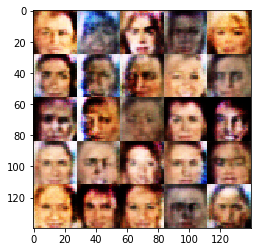

Epoch 1/1... Discriminator Loss: 1.6290... Generator Loss: 0.4781
Epoch 1/1... Discriminator Loss: 0.7268... Generator Loss: 2.6989
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 0.9439
Epoch 1/1... Discriminator Loss: 0.6464... Generator Loss: 2.0073
Epoch 1/1... Discriminator Loss: 1.0357... Generator Loss: 4.6166
Epoch 1/1... Discriminator Loss: 3.3081... Generator Loss: 7.1310
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 0.7438... Generator Loss: 2.4890
Epoch 1/1... Discriminator Loss: 1.0413... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 0.6767... Generator Loss: 1.9242
Epoch 1/1... Discriminator Loss: 0.7658... Generator Loss: 1.7698
Epoch 1/1... Discriminator Loss: 2.2701... Generator Loss: 0.2453
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 0.5799... Generator Loss: 2.3538
Epoch 1/1.

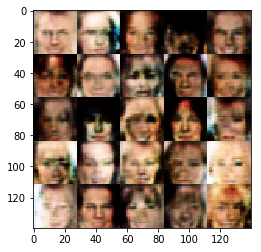

Epoch 1/1... Discriminator Loss: 0.6597... Generator Loss: 2.6453
Epoch 1/1... Discriminator Loss: 2.0192... Generator Loss: 5.4490
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 3.2993
Epoch 1/1... Discriminator Loss: 1.6716... Generator Loss: 4.0680
Epoch 1/1... Discriminator Loss: 0.7528... Generator Loss: 1.5923
Epoch 1/1... Discriminator Loss: 0.5836... Generator Loss: 3.0246
Epoch 1/1... Discriminator Loss: 0.6376... Generator Loss: 2.6300
Epoch 1/1... Discriminator Loss: 1.5283... Generator Loss: 4.1616
Epoch 1/1... Discriminator Loss: 0.7190... Generator Loss: 1.8832
Epoch 1/1... Discriminator Loss: 0.6918... Generator Loss: 1.9543
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 5.6638
Epoch 1/1... Discriminator Loss: 0.7993... Generator Loss: 1.5991
Epoch 1/1... Discriminator Loss: 0.6634... Generator Loss: 1.9679
Epoch 1/1... Discriminator Loss: 0.5706... Generator Loss: 3.6834
Epoch 1/1... Discriminator Loss: 0.7624... Generator Loss: 2.2311
Epoch 1/1.

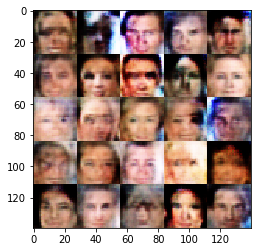

Epoch 1/1... Discriminator Loss: 1.6131... Generator Loss: 3.7346
Epoch 1/1... Discriminator Loss: 0.8654... Generator Loss: 2.6425
Epoch 1/1... Discriminator Loss: 0.8232... Generator Loss: 1.4307
Epoch 1/1... Discriminator Loss: 0.6700... Generator Loss: 1.9918
Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 0.9593
Epoch 1/1... Discriminator Loss: 0.7550... Generator Loss: 1.6329
Epoch 1/1... Discriminator Loss: 0.8828... Generator Loss: 1.1755
Epoch 1/1... Discriminator Loss: 0.7442... Generator Loss: 2.5004
Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 3.5878
Epoch 1/1... Discriminator Loss: 0.6849... Generator Loss: 1.9101
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 0.9921
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 4.5907
Epoch 1/1... Discriminator Loss: 0.7222... Generator Loss: 1.7375
Epoch 1/1... Discriminator Loss: 0.7640... Generator Loss: 1.8181
Epoch 1/1.

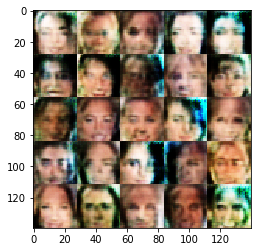

Epoch 1/1... Discriminator Loss: 0.6321... Generator Loss: 2.9620
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 0.7730... Generator Loss: 1.7905
Epoch 1/1... Discriminator Loss: 0.6242... Generator Loss: 2.1500
Epoch 1/1... Discriminator Loss: 0.8170... Generator Loss: 1.3550
Epoch 1/1... Discriminator Loss: 0.6567... Generator Loss: 3.2590
Epoch 1/1... Discriminator Loss: 0.6708... Generator Loss: 1.9135
Epoch 1/1... Discriminator Loss: 0.7033... Generator Loss: 3.1760
Epoch 1/1... Discriminator Loss: 0.9683... Generator Loss: 1.5862
Epoch 1/1... Discriminator Loss: 0.5876... Generator Loss: 2.4633
Epoch 1/1... Discriminator Loss: 1.0236... Generator Loss: 1.5161
Epoch 1/1... Discriminator Loss: 0.6904... Generator Loss: 2.0531
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 5.0632
Epoch 1/1... Discriminator Loss: 0.9786... Generator Loss: 1.1300
Epoch 1/1... Discriminator Loss: 0.8459... Generator Loss: 1.5722
Epoch 1/1.

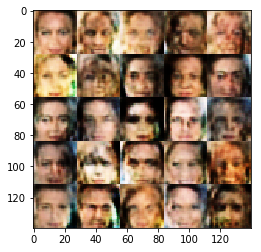

Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 3.8445
Epoch 1/1... Discriminator Loss: 0.7854... Generator Loss: 1.5756
Epoch 1/1... Discriminator Loss: 0.7686... Generator Loss: 1.5153
Epoch 1/1... Discriminator Loss: 0.7149... Generator Loss: 1.8462
Epoch 1/1... Discriminator Loss: 2.0278... Generator Loss: 0.3783
Epoch 1/1... Discriminator Loss: 1.9770... Generator Loss: 0.3734
Epoch 1/1... Discriminator Loss: 0.7563... Generator Loss: 1.7987
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 3.4147
Epoch 1/1... Discriminator Loss: 0.6160... Generator Loss: 2.2139
Epoch 1/1... Discriminator Loss: 1.0270... Generator Loss: 1.0359
Epoch 1/1... Discriminator Loss: 0.8165... Generator Loss: 1.4395
Epoch 1/1... Discriminator Loss: 0.8991... Generator Loss: 1.2518
Epoch 1/1... Discriminator Loss: 0.5816... Generator Loss: 3.2242
Epoch 1/1... Discriminator Loss: 0.7612... Generator Loss: 3.1296
Epoch 1/1... Discriminator Loss: 0.7457... Generator Loss: 1.7610
Epoch 1/1.

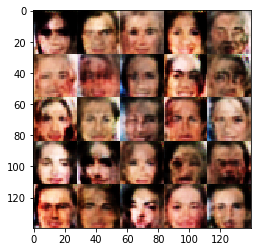

Epoch 1/1... Discriminator Loss: 2.0776... Generator Loss: 4.3840
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 1.1086
Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.8897
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 0.6567... Generator Loss: 1.9523
Epoch 1/1... Discriminator Loss: 0.6367... Generator Loss: 3.5086
Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 1.2845
Epoch 1/1... Discriminator Loss: 0.8273... Generator Loss: 1.4956
Epoch 1/1... Discriminator Loss: 0.7162... Generator Loss: 1.7593
Epoch 1/1... Discriminator Loss: 0.8004... Generator Loss: 2.9842
Epoch 1/1... Discriminator Loss: 0.7518... Generator Loss: 1.7528
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 1.0434
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.9584
Epoch 1/1.

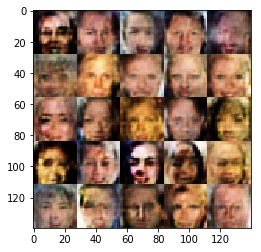

Epoch 1/1... Discriminator Loss: 0.7173... Generator Loss: 2.0570
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 0.6715... Generator Loss: 2.1358
Epoch 1/1... Discriminator Loss: 0.6595... Generator Loss: 2.2455
Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 1.6659
Epoch 1/1... Discriminator Loss: 0.6281... Generator Loss: 2.4377
Epoch 1/1... Discriminator Loss: 0.9007... Generator Loss: 3.4116
Epoch 1/1... Discriminator Loss: 0.5768... Generator Loss: 2.9509
Epoch 1/1... Discriminator Loss: 0.6871... Generator Loss: 2.1558
Epoch 1/1... Discriminator Loss: 0.6057... Generator Loss: 3.2183
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 1.0488
Epoch 1/1... Discriminator Loss: 0.7939... Generator Loss: 1.6789
Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 1.2312
Epoch 1/1... Discriminator Loss: 0.7296... Generator Loss: 1.9111
Epoch 1/1... Discriminator Loss: 0.6224... Generator Loss: 2.4531
Epoch 1/1.

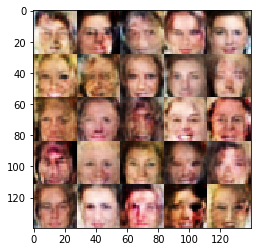

Epoch 1/1... Discriminator Loss: 0.8131... Generator Loss: 1.4495
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.7053... Generator Loss: 4.7404
Epoch 1/1... Discriminator Loss: 1.8356... Generator Loss: 0.4122
Epoch 1/1... Discriminator Loss: 0.7635... Generator Loss: 1.7921
Epoch 1/1... Discriminator Loss: 0.5965... Generator Loss: 2.6387
Epoch 1/1... Discriminator Loss: 0.7265... Generator Loss: 2.0054
Epoch 1/1... Discriminator Loss: 0.7021... Generator Loss: 2.1434
Epoch 1/1... Discriminator Loss: 0.6156... Generator Loss: 3.1804
Epoch 1/1... Discriminator Loss: 1.0157... Generator Loss: 1.2174
Epoch 1/1... Discriminator Loss: 0.8587... Generator Loss: 1.4672
Epoch 1/1... Discriminator Loss: 0.6437... Generator Loss: 2.1536
Epoch 1/1... Discriminator Loss: 0.9539... Generator Loss: 1.4279
Epoch 1/1... Discriminator Loss: 0.7528... Generator Loss: 2.0293
Epoch 1/1... Discriminator Loss: 0.8376... Generator Loss: 1.4742
Epoch 1/1.

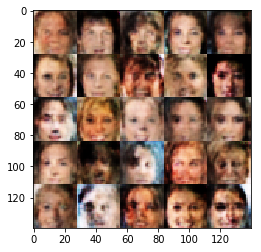

Epoch 1/1... Discriminator Loss: 0.8657... Generator Loss: 1.2926
Epoch 1/1... Discriminator Loss: 0.8503... Generator Loss: 1.5613
Epoch 1/1... Discriminator Loss: 1.9226... Generator Loss: 6.5462
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 1.1281
Epoch 1/1... Discriminator Loss: 1.9177... Generator Loss: 0.4437
Epoch 1/1... Discriminator Loss: 0.8130... Generator Loss: 1.6027
Epoch 1/1... Discriminator Loss: 0.8868... Generator Loss: 1.2545
Epoch 1/1... Discriminator Loss: 1.6834... Generator Loss: 0.5151
Epoch 1/1... Discriminator Loss: 0.8488... Generator Loss: 1.4836
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 1.0446
Epoch 1/1... Discriminator Loss: 0.9927... Generator Loss: 1.4896
Epoch 1/1... Discriminator Loss: 0.7021... Generator Loss: 2.2955
Epoch 1/1... Discriminator Loss: 0.8306... Generator Loss: 3.3061
Epoch 1/1... Discriminator Loss: 0.6033... Generator Loss: 2.9810
Epoch 1/1... Discriminator Loss: 0.6749... Generator Loss: 1.9579
Epoch 1/1.

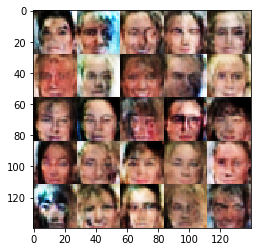

Epoch 1/1... Discriminator Loss: 0.6578... Generator Loss: 1.9632
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 1.1092
Epoch 1/1... Discriminator Loss: 0.7032... Generator Loss: 2.2215
Epoch 1/1... Discriminator Loss: 1.0705... Generator Loss: 5.6983
Epoch 1/1... Discriminator Loss: 0.7531... Generator Loss: 1.6556
Epoch 1/1... Discriminator Loss: 0.8274... Generator Loss: 1.5195
Epoch 1/1... Discriminator Loss: 0.7082... Generator Loss: 3.6614
Epoch 1/1... Discriminator Loss: 0.8261... Generator Loss: 3.3045
Epoch 1/1... Discriminator Loss: 0.6192... Generator Loss: 2.2463
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.8665
Epoch 1/1... Discriminator Loss: 0.6857... Generator Loss: 1.9965
Epoch 1/1... Discriminator Loss: 0.7276... Generator Loss: 1.8879
Epoch 1/1... Discriminator Loss: 0.4732... Generator Loss: 5.6432
Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 3.2161
Epoch 1/1... Discriminator Loss: 0.8585... Generator Loss: 3.5750
Epoch 1/1.

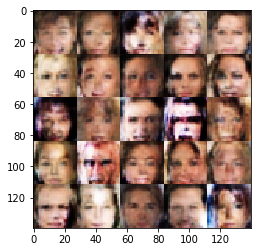

Epoch 1/1... Discriminator Loss: 2.1148... Generator Loss: 0.3240
Epoch 1/1... Discriminator Loss: 0.8125... Generator Loss: 1.4971
Epoch 1/1... Discriminator Loss: 1.0147... Generator Loss: 1.0510
Epoch 1/1... Discriminator Loss: 0.8074... Generator Loss: 1.5361
Epoch 1/1... Discriminator Loss: 0.7316... Generator Loss: 1.8573
Epoch 1/1... Discriminator Loss: 1.5408... Generator Loss: 4.6970
Epoch 1/1... Discriminator Loss: 0.6376... Generator Loss: 2.1879
Epoch 1/1... Discriminator Loss: 1.1530... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 0.7216... Generator Loss: 1.6919
Epoch 1/1... Discriminator Loss: 0.7049... Generator Loss: 1.8645
Epoch 1/1... Discriminator Loss: 0.7697... Generator Loss: 2.6028
Epoch 1/1... Discriminator Loss: 0.7886... Generator Loss: 2.0863
Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 4.0209
Epoch 1/1... Discriminator Loss: 0.7791... Generator Loss: 2.8947
Epoch 1/1... Discriminator Loss: 0.5927... Generator Loss: 2.6334
Epoch 1/1.

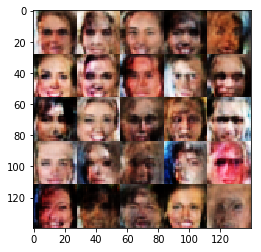

Epoch 1/1... Discriminator Loss: 0.7647... Generator Loss: 1.8762
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 5.1933
Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 2.9819
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 0.7266... Generator Loss: 1.7449
Epoch 1/1... Discriminator Loss: 0.7143... Generator Loss: 2.0877
Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 1.1051
Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 1.2257
Epoch 1/1... Discriminator Loss: 1.9884... Generator Loss: 0.5236
Epoch 1/1... Discriminator Loss: 0.9246... Generator Loss: 1.2868
Epoch 1/1... Discriminator Loss: 0.7423... Generator Loss: 1.6956
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 5.2140
Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 3.4223
Epoch 1/1... Discriminator Loss: 2.2913... Generator Loss: 0.2608
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.7779
Epoch 1/1.

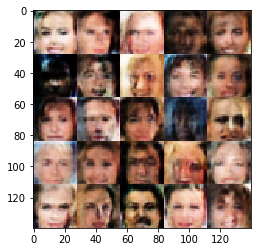

Epoch 1/1... Discriminator Loss: 1.7263... Generator Loss: 0.5788
Epoch 1/1... Discriminator Loss: 0.6876... Generator Loss: 2.1682
Epoch 1/1... Discriminator Loss: 0.9713... Generator Loss: 3.5365
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 1.1185
Epoch 1/1... Discriminator Loss: 0.7135... Generator Loss: 2.1011
Epoch 1/1... Discriminator Loss: 0.7646... Generator Loss: 1.7019
Epoch 1/1... Discriminator Loss: 1.6735... Generator Loss: 0.4477
Epoch 1/1... Discriminator Loss: 0.8426... Generator Loss: 3.6842
Epoch 1/1... Discriminator Loss: 0.7137... Generator Loss: 3.3550
Epoch 1/1... Discriminator Loss: 0.9044... Generator Loss: 3.1207
Epoch 1/1... Discriminator Loss: 0.7083... Generator Loss: 2.2356
Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 0.9797
Epoch 1/1... Discriminator Loss: 0.7994... Generator Loss: 1.6316
Epoch 1/1... Discriminator Loss: 0.8545... Generator Loss: 3.8105
Epoch 1/1... Discriminator Loss: 0.6397... Generator Loss: 2.3007
Epoch 1/1.

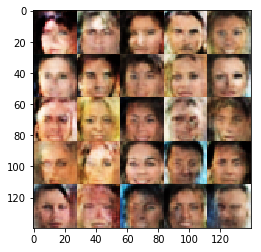

Epoch 1/1... Discriminator Loss: 0.7739... Generator Loss: 1.7143
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 0.6514... Generator Loss: 3.7177
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 2.9983
Epoch 1/1... Discriminator Loss: 0.6137... Generator Loss: 2.3984
Epoch 1/1... Discriminator Loss: 0.7436... Generator Loss: 1.6169
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 1.0185
Epoch 1/1... Discriminator Loss: 0.6880... Generator Loss: 1.8387
Epoch 1/1... Discriminator Loss: 0.8967... Generator Loss: 1.4159
Epoch 1/1... Discriminator Loss: 0.6657... Generator Loss: 2.2370
Epoch 1/1... Discriminator Loss: 0.7003... Generator Loss: 1.8740
Epoch 1/1.

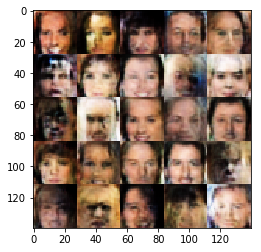

Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 1.1631
Epoch 1/1... Discriminator Loss: 0.9079... Generator Loss: 1.3833
Epoch 1/1... Discriminator Loss: 0.8190... Generator Loss: 2.0102
Epoch 1/1... Discriminator Loss: 0.6182... Generator Loss: 2.6971
Epoch 1/1... Discriminator Loss: 0.6945... Generator Loss: 1.9951
Epoch 1/1... Discriminator Loss: 0.6048... Generator Loss: 2.4198
Epoch 1/1... Discriminator Loss: 0.9384... Generator Loss: 1.6570
Epoch 1/1... Discriminator Loss: 0.8311... Generator Loss: 2.8916
Epoch 1/1... Discriminator Loss: 1.0274... Generator Loss: 3.1610
Epoch 1/1... Discriminator Loss: 0.9464... Generator Loss: 1.1212
Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 1.5504
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 0.6331... Generator Loss: 2.5059
Epoch 1/1... Discriminator Loss: 0.5642... Generator Loss: 3.4630
Epoch 1/1... Discriminator Loss: 0.6542... Generator Loss: 2.2270
Epoch 1/1.

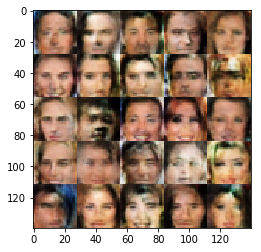

Epoch 1/1... Discriminator Loss: 0.6911... Generator Loss: 1.9839
Epoch 1/1... Discriminator Loss: 0.7166... Generator Loss: 1.7233
Epoch 1/1... Discriminator Loss: 0.6889... Generator Loss: 3.6128
Epoch 1/1... Discriminator Loss: 0.6514... Generator Loss: 3.5188
Epoch 1/1... Discriminator Loss: 0.7583... Generator Loss: 1.6600
Epoch 1/1... Discriminator Loss: 0.8311... Generator Loss: 1.7653
Epoch 1/1... Discriminator Loss: 0.7686... Generator Loss: 3.0843
Epoch 1/1... Discriminator Loss: 0.6291... Generator Loss: 2.1929
Epoch 1/1... Discriminator Loss: 0.8568... Generator Loss: 4.3842
Epoch 1/1... Discriminator Loss: 0.8477... Generator Loss: 2.5797
Epoch 1/1... Discriminator Loss: 0.8531... Generator Loss: 1.4320
Epoch 1/1... Discriminator Loss: 0.8349... Generator Loss: 1.6851
Epoch 1/1... Discriminator Loss: 0.8945... Generator Loss: 1.4405
Epoch 1/1... Discriminator Loss: 0.5838... Generator Loss: 2.6827
Epoch 1/1... Discriminator Loss: 0.6819... Generator Loss: 2.0196
Epoch 1/1.

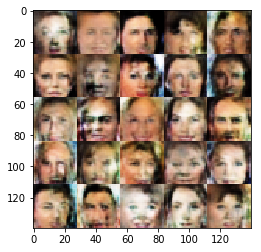

Epoch 1/1... Discriminator Loss: 0.6170... Generator Loss: 3.0244
Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 1.2774
Epoch 1/1... Discriminator Loss: 0.4969... Generator Loss: 4.9288
Epoch 1/1... Discriminator Loss: 2.9559... Generator Loss: 7.1986
Epoch 1/1... Discriminator Loss: 0.7369... Generator Loss: 2.0139
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 1.9023
Epoch 1/1... Discriminator Loss: 0.6150... Generator Loss: 4.4685
Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 0.9561
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.9216
Epoch 1/1... Discriminator Loss: 0.8921... Generator Loss: 1.4054
Epoch 1/1... Discriminator Loss: 0.7043... Generator Loss: 2.6347
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 1.0437
Epoch 1/1... Discriminator Loss: 0.8247... Generator Loss: 1.9030
Epoch 1/1... Discriminator Loss: 0.7587... Generator Loss: 5.5970
Epoch 1/1.

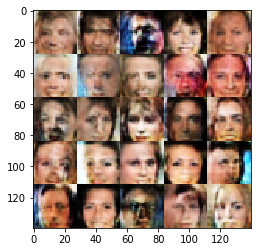

Epoch 1/1... Discriminator Loss: 0.7442... Generator Loss: 1.8584
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 0.7418... Generator Loss: 1.6714
Epoch 1/1... Discriminator Loss: 1.5215... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 0.6539... Generator Loss: 2.7578
Epoch 1/1... Discriminator Loss: 0.8496... Generator Loss: 1.3690
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 4.2259
Epoch 1/1... Discriminator Loss: 0.7640... Generator Loss: 2.7065
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 0.7518... Generator Loss: 1.7231
Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 0.5832... Generator Loss: 3.1632
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 4.7882
Epoch 1/1... Discriminator Loss: 1.5943... Generator Loss: 0.4834
Epoch 1/1... Discriminator Loss: 0.7191... Generator Loss: 2.2595
Epoch 1/1.

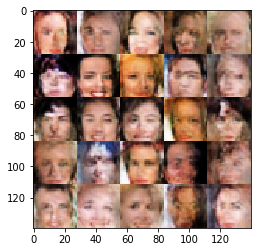

Epoch 1/1... Discriminator Loss: 0.6744... Generator Loss: 1.8777
Epoch 1/1... Discriminator Loss: 1.0362... Generator Loss: 4.8354
Epoch 1/1... Discriminator Loss: 0.5625... Generator Loss: 3.0469
Epoch 1/1... Discriminator Loss: 0.4650... Generator Loss: 6.0080
Epoch 1/1... Discriminator Loss: 0.7741... Generator Loss: 1.5565
Epoch 1/1... Discriminator Loss: 0.6614... Generator Loss: 1.9725
Epoch 1/1... Discriminator Loss: 0.8314... Generator Loss: 1.3597
Epoch 1/1... Discriminator Loss: 0.6270... Generator Loss: 2.4998
Epoch 1/1... Discriminator Loss: 0.4565... Generator Loss: 7.5683
Epoch 1/1... Discriminator Loss: 0.5400... Generator Loss: 3.3084
Epoch 1/1... Discriminator Loss: 0.5296... Generator Loss: 2.9084
Epoch 1/1... Discriminator Loss: 0.5279... Generator Loss: 3.2688
Epoch 1/1... Discriminator Loss: 0.5215... Generator Loss: 4.5950
Epoch 1/1... Discriminator Loss: 0.6142... Generator Loss: 2.1888
Epoch 1/1... Discriminator Loss: 0.5317... Generator Loss: 3.0999
Epoch 1/1.

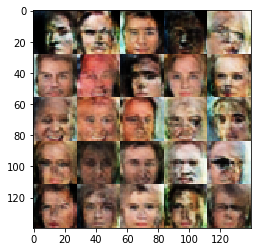

Epoch 1/1... Discriminator Loss: 0.6482... Generator Loss: 1.9281
Epoch 1/1... Discriminator Loss: 0.7934... Generator Loss: 1.9089
Epoch 1/1... Discriminator Loss: 2.9548... Generator Loss: 0.1721
Epoch 1/1... Discriminator Loss: 2.1016... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 0.7633... Generator Loss: 2.1666
Epoch 1/1... Discriminator Loss: 1.5489... Generator Loss: 0.5558
Epoch 1/1... Discriminator Loss: 0.8280... Generator Loss: 1.8717
Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 4.1250
Epoch 1/1... Discriminator Loss: 0.6778... Generator Loss: 2.0745
Epoch 1/1... Discriminator Loss: 0.7345... Generator Loss: 1.8890
Epoch 1/1... Discriminator Loss: 0.6631... Generator Loss: 3.3001
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 1.0364
Epoch 1/1... Discriminator Loss: 0.8537... Generator Loss: 1.2802
Epoch 1/1... Discriminator Loss: 0.6856... Generator Loss: 2.9326
Epoch 1/1... Discriminator Loss: 1.0167... Generator Loss: 1.0991
Epoch 1/1.

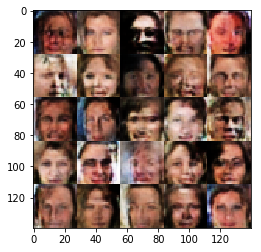

Epoch 1/1... Discriminator Loss: 1.9671... Generator Loss: 0.3872
Epoch 1/1... Discriminator Loss: 0.9016... Generator Loss: 1.2749
Epoch 1/1... Discriminator Loss: 0.9545... Generator Loss: 3.5962
Epoch 1/1... Discriminator Loss: 0.8347... Generator Loss: 1.3879
Epoch 1/1... Discriminator Loss: 0.7644... Generator Loss: 3.1680
Epoch 1/1... Discriminator Loss: 0.8766... Generator Loss: 1.2620
Epoch 1/1... Discriminator Loss: 0.9860... Generator Loss: 1.3141
Epoch 1/1... Discriminator Loss: 0.6237... Generator Loss: 2.5450
Epoch 1/1... Discriminator Loss: 0.7549... Generator Loss: 3.6759
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.5261... Generator Loss: 0.5592
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 0.6248... Generator Loss: 2.1924
Epoch 1/1... Discriminator Loss: 0.6689... Generator Loss: 2.1421
Epoch 1/1... Discriminator Loss: 0.7431... Generator Loss: 1.7962
Epoch 1/1.

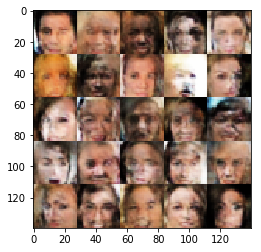

Epoch 1/1... Discriminator Loss: 0.6975... Generator Loss: 1.6824
Epoch 1/1... Discriminator Loss: 0.5904... Generator Loss: 2.3903
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 1.0179
Epoch 1/1... Discriminator Loss: 0.6443... Generator Loss: 2.0876
Epoch 1/1... Discriminator Loss: 0.7936... Generator Loss: 1.5412
Epoch 1/1... Discriminator Loss: 1.5107... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.6399... Generator Loss: 0.4868
Epoch 1/1... Discriminator Loss: 0.6555... Generator Loss: 2.1146
Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 1.0193
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 1.3486
Epoch 1/1... Discriminator Loss: 0.5517... Generator Loss: 2.5984
Epoch 1/1... Discriminator Loss: 1.7638... Generator Loss: 0.5140
Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 1.3672
Epoch 1/1... Discriminator Loss: 1.7955... Generator Loss: 0.4890
Epoch 1/1.

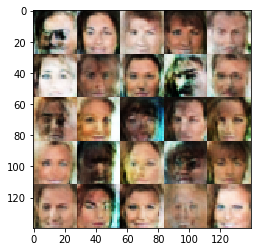

Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 1.7365
Epoch 1/1... Discriminator Loss: 2.2971... Generator Loss: 0.2797
Epoch 1/1... Discriminator Loss: 0.9032... Generator Loss: 1.5461
Epoch 1/1... Discriminator Loss: 0.7007... Generator Loss: 1.9149
Epoch 1/1... Discriminator Loss: 0.7800... Generator Loss: 1.6514
Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 1.2930
Epoch 1/1... Discriminator Loss: 0.6254... Generator Loss: 2.4856
Epoch 1/1... Discriminator Loss: 0.7209... Generator Loss: 1.8904
Epoch 1/1... Discriminator Loss: 0.7456... Generator Loss: 2.8388
Epoch 1/1... Discriminator Loss: 0.6984... Generator Loss: 1.8179
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 1.0142
Epoch 1/1... Discriminator Loss: 0.5833... Generator Loss: 2.7015
Epoch 1/1... Discriminator Loss: 0.7401... Generator Loss: 1.8502
Epoch 1/1... Discriminator Loss: 0.8533... Generator Loss: 2.1620
Epoch 1/1... Discriminator Loss: 0.5694... Generator Loss: 3.1817
Epoch 1/1.

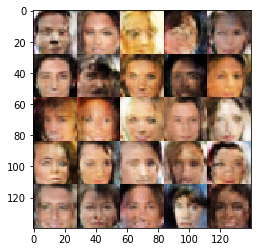

Epoch 1/1... Discriminator Loss: 0.5595... Generator Loss: 3.1359
Epoch 1/1... Discriminator Loss: 0.7586... Generator Loss: 1.5733
Epoch 1/1... Discriminator Loss: 0.7200... Generator Loss: 1.7575
Epoch 1/1... Discriminator Loss: 0.8865... Generator Loss: 1.3493
Epoch 1/1... Discriminator Loss: 1.0633... Generator Loss: 1.1836
Epoch 1/1... Discriminator Loss: 0.6012... Generator Loss: 3.1217
Epoch 1/1... Discriminator Loss: 0.7013... Generator Loss: 2.0983
Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 5.2653
Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 1.2686
Epoch 1/1... Discriminator Loss: 0.7973... Generator Loss: 2.5774
Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 0.9997
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.9839
Epoch 1/1... Discriminator Loss: 0.6283... Generator Loss: 2.4264
Epoch 1/1... Discriminator Loss: 0.6572... Generator Loss: 2.3444
Epoch 1/1... Discriminator Loss: 0.5507... Generator Loss: 3.5051
Epoch 1/1.

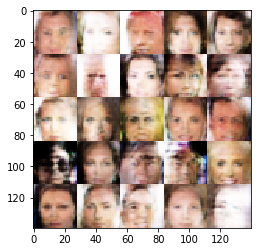

Epoch 1/1... Discriminator Loss: 0.6923... Generator Loss: 1.8770
Epoch 1/1... Discriminator Loss: 1.8407... Generator Loss: 0.4874
Epoch 1/1... Discriminator Loss: 0.8332... Generator Loss: 1.4998
Epoch 1/1... Discriminator Loss: 0.6084... Generator Loss: 2.3734
Epoch 1/1... Discriminator Loss: 0.8595... Generator Loss: 1.3681
Epoch 1/1... Discriminator Loss: 0.6359... Generator Loss: 2.0483
Epoch 1/1... Discriminator Loss: 0.8664... Generator Loss: 3.3417
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 0.5596... Generator Loss: 3.5066
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 2.8585
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 2.5298
Epoch 1/1... Discriminator Loss: 0.6930... Generator Loss: 1.9818
Epoch 1/1... Discriminator Loss: 0.8745... Generator Loss: 1.7839
Epoch 1/1... Discriminator Loss: 0.6804... Generator Loss: 2.3327
Epoch 1/1... Discriminator Loss: 0.7034... Generator Loss: 1.7938
Epoch 1/1.

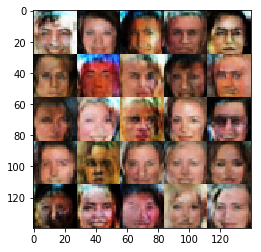

Epoch 1/1... Discriminator Loss: 0.6735... Generator Loss: 1.9290
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 4.3451
Epoch 1/1... Discriminator Loss: 0.8865... Generator Loss: 1.3286
Epoch 1/1... Discriminator Loss: 0.6776... Generator Loss: 2.2926
Epoch 1/1... Discriminator Loss: 0.8804... Generator Loss: 1.3210
Epoch 1/1... Discriminator Loss: 0.6894... Generator Loss: 1.9500
Epoch 1/1... Discriminator Loss: 0.6556... Generator Loss: 2.1499
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 1.3274
Epoch 1/1... Discriminator Loss: 0.6674... Generator Loss: 2.1211
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 0.7963... Generator Loss: 1.4453
Epoch 1/1... Discriminator Loss: 0.7111... Generator Loss: 2.9212
Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 1.2497


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.